# Gaussian Process Regression (GPR)
In this experiment, we try to visualize how Gaussian Process Regression (GPR) works by modeling a simple equation with sinusoidal and linear components. We try out different kernels (and a combination of some) to see how it affects our results. We used [Gaussian Processes by DataMListic](https://www.youtube.com/watch?v=BTEbaPoZ08Y) as our reference for this notebook.

In [1]:
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, DotProduct, ExpSineSquared, Sum

For our experiment, we want our GPR to correctly model the equation $y=x+sin(2x)$ by using only a few observations of this equation. Let's generate 100 evenly-spaced samples from the equation.

In [2]:
X = np.linspace(-5, 5, 100).reshape(-1, 1)
y = X + np.sin(2*X)

We plot the equation to have a better view of what it looks like.

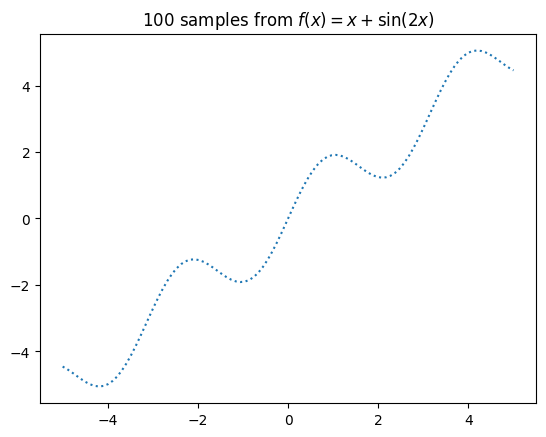

In [3]:
plt.plot(X, y, linestyle="dotted")
plt.title(r"100 samples from $f(x) = x + \sin(2x)$")
plt.show()

We only take 10 out of this 100 samples as our observations. We see that there are no observations from $[-5, -2.3)$ even though we sampled from $[-5, 5]$. It would be interesting to see how the models deal with this (and if they overfit).

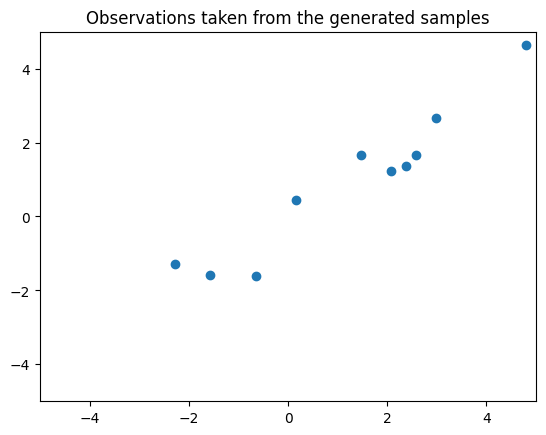

In [4]:
X_train, _, y_train, _ = train_test_split(
    X, y, test_size=0.9, random_state=59382
)
plt.scatter(X_train, y_train)
plt.title("Observations taken from the generated samples")
plt.xlim(-5, 5)
plt.ylim(-5, 5)
plt.show()

We instantiate 4 Gaussian Process Regressors with different kernels and compare how well they model the equation given these few observations.
1. Radial Basis Function Kernel  - `RBF()`
2. Periodic Kernel - `ExpSineSquared()`
3. Linear Kernel - `DotProduct()`
4. Periodic + Linear Kernel - `Sum(ExpSineSquared(), DotProduct())`

Moreover, we keep the default GP prior's mean to 0 ($\mu = 0$).

In [5]:
rbf_gp = GaussianProcessRegressor(kernel=RBF())
rbf_gp.fit(X_train, y_train)

sin_gp = GaussianProcessRegressor(kernel=ExpSineSquared())
sin_gp.fit(X_train, y_train)

lin_gp = GaussianProcessRegressor(kernel=DotProduct())
lin_gp.fit(X_train, y_train)

sin_lin_gp = GaussianProcessRegressor(kernel=Sum(ExpSineSquared(), DotProduct()))
sin_lin_gp.fit(X_train, y_train)

,kernel,ExpSineSquare...uct(sigma_0=1)
,alpha,1e-10
,optimizer,'fmin_l_bfgs_b'
,n_restarts_optimizer,0
,normalize_y,False
,copy_X_train,True
,n_targets,None
,random_state,None
,kernel__k1,ExpSineSquare...periodicity=1)
,kernel__k2,DotProduct(sigma_0=1)
,kernel__k1__length_scale,1.0


The first GPR is with the radial basis function as its kernel. It is one of the more complex kernels (and the most complex out of the four setups we have in this notebook), which means it can also handle complex functions better than the next three kernels. 

However, it also means that it is prone to overfitting, which is what we observe. Although it does very well in estimating the function from around $[-2.3, 5]$ with very little uncertainty, it has failed to generalize and is way off from $[-5, -2.3)$ since it has not seen any data points from that range. As a result, we also see that the GPR with RBF kernel is not confident in its estimation from $[-5, -2.3)$ with high uncertainty compared to its estimation from $[-2.3, 5]$.

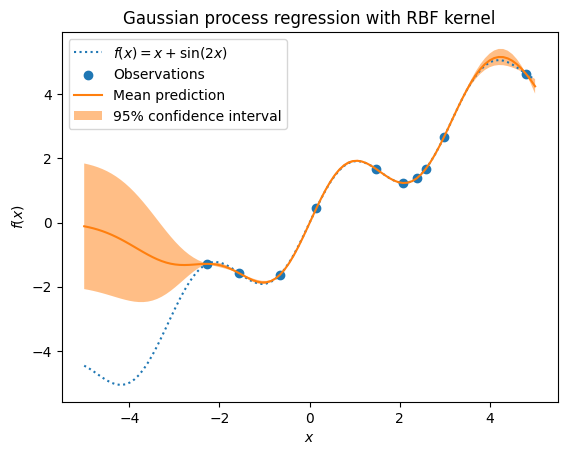

In [6]:
mean_prediction, std_prediction = rbf_gp.predict(X.reshape(-1,1), return_std=True)

plt.plot(X, y, label=r"$f(x) = x + \sin(2x)$", linestyle="dotted")
plt.scatter(X_train, y_train, label="Observations")
plt.plot(X, mean_prediction, label="Mean prediction")
plt.fill_between(
    X.ravel(),
    mean_prediction - 1.96 * std_prediction,
    mean_prediction + 1.96 * std_prediction,
    alpha=0.5,
    label=r"95% confidence interval",
)
plt.legend()
plt.xlabel("$x$")
plt.ylabel("$f(x)$")
_ = plt.title("Gaussian process regression with RBF kernel")

For the GPR with periodic kernel, it captures the periodicity of the function but it cannot estimate its linearly increasing property, contributed by the $x$ in $y = x+sin(2x)$, due to the limitations of the kernel itself. We can try to correct this by adding another kernel that models this linear property (as seen in the last GPR setup in this notebook).

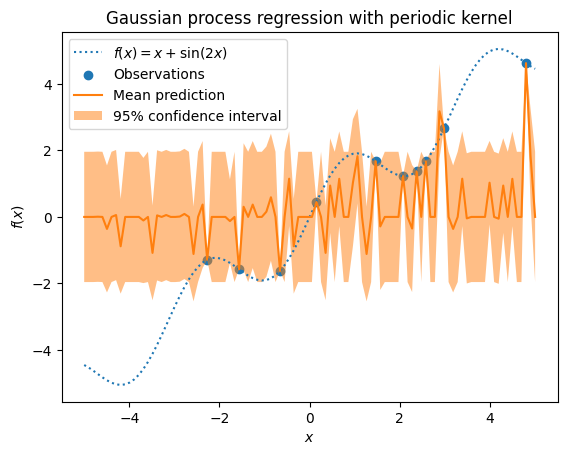

In [7]:
mean_prediction, std_prediction = sin_gp.predict(X.reshape(-1,1), return_std=True)

plt.plot(X, y, label=r"$f(x) = x + \sin(2x)$", linestyle="dotted")
plt.scatter(X_train, y_train, label="Observations")
plt.plot(X, mean_prediction, label="Mean prediction")
plt.fill_between(
    X.ravel(),
    mean_prediction - 1.96 * std_prediction,
    mean_prediction + 1.96 * std_prediction,
    alpha=0.5,
    label=r"95% confidence interval",
)
plt.legend()
plt.xlabel("$x$")
plt.ylabel("$f(x)$")
_ = plt.title("Gaussian process regression with periodic kernel")

The results of the GPR with the linear kernel is opposite to that of the periodic kernel. It properly captures the linearly increasing property of the function, but fails to estimate its periodicity, contributed by the $sin(2x)$ in $y = x+sin(2x)$, due to the limitations of the kernel. 

Another interesting observation is that its uncertainty is very low compared to all other GPRs of different kernels. This could be because the linear kernel has very little flexibility in its possible functions, which is why it is certain that the observations probably follow a $y=x$ behavior.

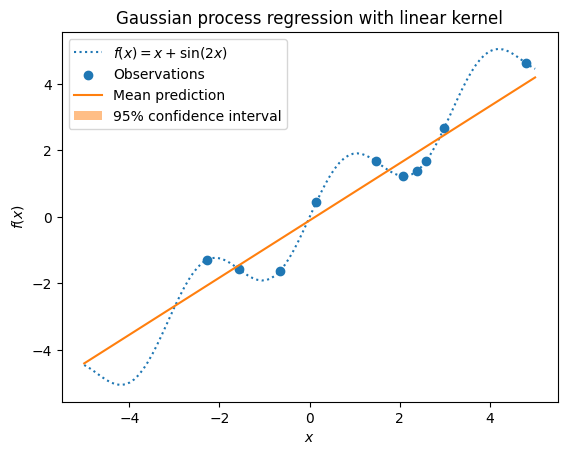

In [8]:
mean_prediction, std_prediction = lin_gp.predict(X.reshape(-1,1), return_std=True)

plt.plot(X, y, label=r"$f(x) = x + \sin(2x)$", linestyle="dotted")
plt.scatter(X_train, y_train, label="Observations")
plt.plot(X, mean_prediction, label="Mean prediction")
plt.fill_between(
    X.ravel(),
    mean_prediction - 1.96 * std_prediction,
    mean_prediction + 1.96 * std_prediction,
    alpha=0.5,
    label=r"95% confidence interval",
)
plt.legend()
plt.xlabel("$x$")
plt.ylabel("$f(x)$")
_ = plt.title("Gaussian process regression with linear kernel")

Finally, since we observed that the periodic kernel can estimate the $sin(2x)$ component while the linear kernel can estimate the $x$ component of the function, then we can combine these two kernels together and see how it performs the estimation.

As observed, we see that although it is not a perfect sinusoid, the mean prediction of the GPR now has both periodic and linear properties. It is not as smooth as the predictions with the RBF kernel, but the estimates of the periodic + linear kernel at $[-5, -2.3)$ is much closer to the sampled values, showing a more generalized estimation of the function.

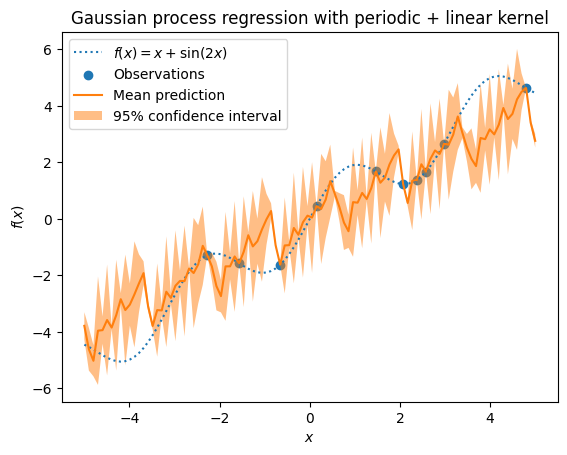

In [9]:
mean_prediction, std_prediction = sin_lin_gp.predict(X.reshape(-1,1), return_std=True)

plt.plot(X, y, label=r"$f(x) = x + \sin(2x)$", linestyle="dotted")
plt.scatter(X_train, y_train, label="Observations")
plt.plot(X, mean_prediction, label="Mean prediction")
plt.fill_between(
    X.ravel(),
    mean_prediction - 1.96 * std_prediction,
    mean_prediction + 1.96 * std_prediction,
    alpha=0.5,
    label=r"95% confidence interval",
)
plt.legend()
plt.xlabel("$x$")
plt.ylabel("$f(x)$")
_ = plt.title("Gaussian process regression with periodic + linear kernel")